# **Motorbike Ambulance Calls**
>Motorbike accidents and corresponded ambulance calls are highly depended on environmental and seasonal settings, like weather conditions, precipitation, day of week, season, hour of the day, etc. The data was aggregated over the course of two years, on hourly basis, and then extracted and extended with the corresponding weather and seasonal information.


## **Associated tasks**

---


**Regression**

Prediction of the hourly ambulance calls count based on the environmental and seasonal settings. Prediction model should provide monotonic in the terms of some features, if it is proved by data.

**Event and Anomaly Detection**

Define the  ambulance calls patterns with respect of special events and define the cases that might be considered as abnormal behavior.  

**Deliverables**

Full Texts Report that contains detail description of Data Analysis, Data Modelling and Patterns/Anomaly detection processes with conclusions and their explanations.
What is important here:
* See the **way you’re thinking** – what actions you’re implementing and why
* How **you code** and wrangle the data
* **Storytelling** capabilities – so we’re looking for the full-text structured report separately from the code/notebook
* **Suggestions** on the further  analytics/approaches which could be applied

## **Dataset characteristics:**

---



motorbike_ambulance_calls.csv has the following fields:

              - index: record index
              - date : date
              - season : season (1:springer, 2:summer, 3:fall, 4:winter)
              - yr : year (0: 2011, 1:2012)
              - mnth : month ( 1 to 12)
              - hr : hour (0 to 23)
              - holiday : whether day is holiday or not
              - weekday : day of the week
              - workingday : if day is neither weekend nor holiday is 1, otherwise is 0.
              -  weathersit :
                      - 1: Clear, Few clouds, Partly cloudy, Partly cloudy
                      - 2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist
                      - 3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds
                      - 4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog
              - temp : Normalized temperature in Celsius. The values are divided to 41 (max)
              - atemp: Normalized feeling temperature in Celsius. The values are divided to 50 (max)
              - hum: Normalized humidity. The values are divided to 100 (max)
              - windspeed: Normalized wind speed. The values are divided to 67 (max)
              - cnt: count of total ambulance calls

In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import xgboost as xgb

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17379 entries, 0 to 17378
Data columns (total 15 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   index       17379 non-null  int64  
 1   date        17379 non-null  object 
 2   season      17379 non-null  object 
 3   yr          17379 non-null  int64  
 4   mnth        17379 non-null  int64  
 5   hr          17379 non-null  int64  
 6   holiday     17379 non-null  int64  
 7   weekday     17379 non-null  int64  
 8   workingday  17379 non-null  int64  
 9   weathersit  17379 non-null  int64  
 10  temp        17379 non-null  float64
 11  atemp       17379 non-null  float64
 12  hum         17379 non-null  float64
 13  windspeed   17379 non-null  float64
 14  cnt         17379 non-null  int64  
dtypes: float64(4), int64(9), object(2)
memory usage: 2.0+ MB
None
            index            yr          mnth            hr       holiday  \
count  17379.0000  17379.000000  17379.000000  173

C:\Users\Administrator\AppData\Local\Temp\ipykernel_6400\4102083506.py:13: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  data['date'] = pd.to_datetime(data['date'])


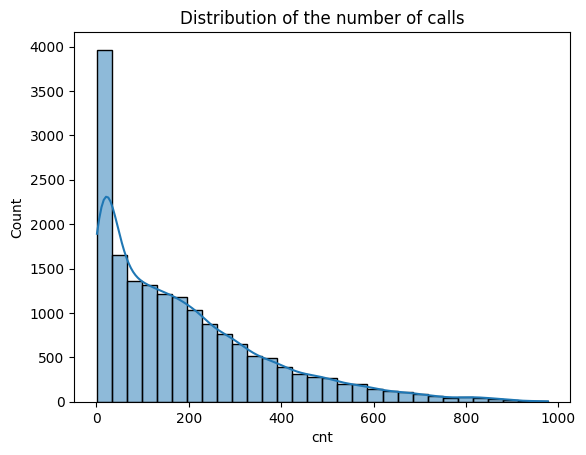

In [4]:
data = pd.read_csv('motorbike_ambulance_calls.csv')

print(data.info())
print(data.describe())

print(data.isnull().sum())

data = data.drop_duplicates()

categorical_cols = ['season', 'holiday', 'weekday', 'workingday', 'weathersit']
data[categorical_cols] = data[categorical_cols].astype('category')

data['date'] = pd.to_datetime(data['date'])

sns.histplot(data['cnt'], bins=30, kde=True)
plt.title("Distribution of the number of calls")
plt.show()

C:\Users\Administrator\AppData\Local\Temp\ipykernel_6400\1477834335.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  season_calls = data.groupby('season')['cnt'].mean()


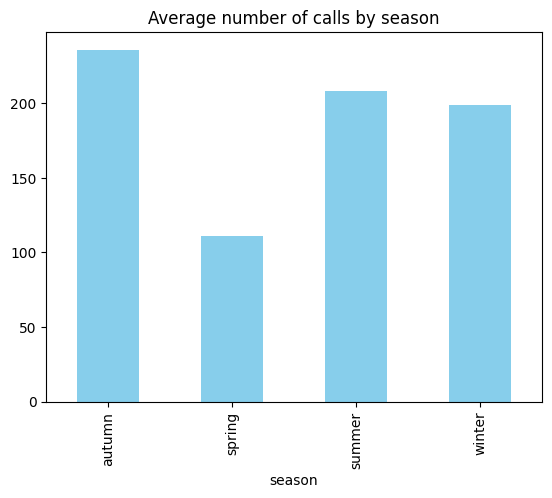

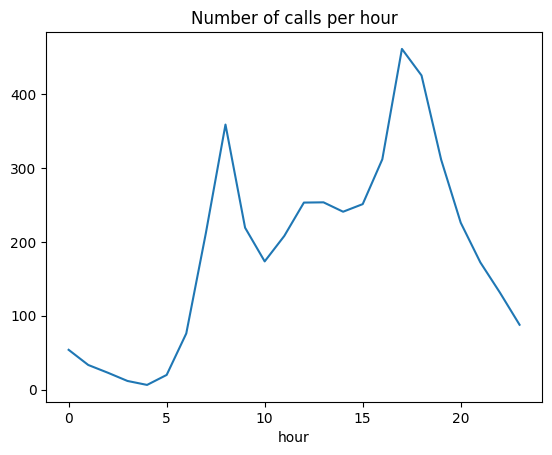

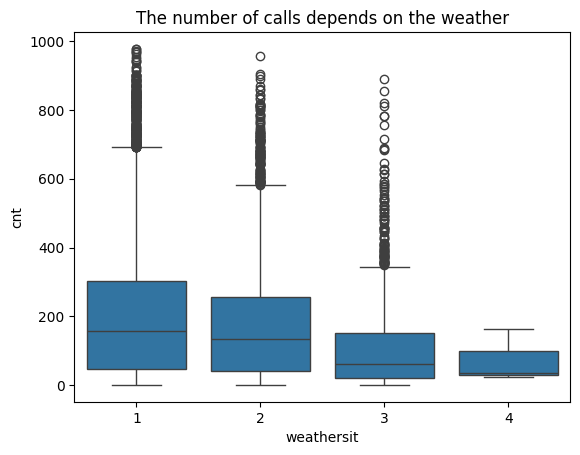

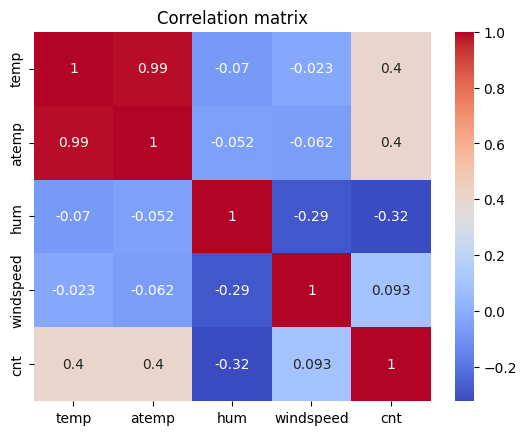

C:\Users\Administrator\AppData\Local\Temp\ipykernel_6400\1477834335.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=data, x='season', y='cnt', palette='Set2')


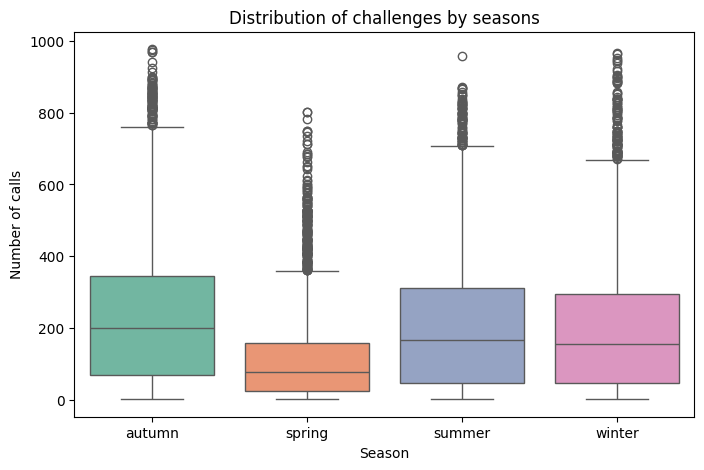

In [12]:
season_calls = data.groupby('season')['cnt'].mean()
season_calls.plot(kind='bar', color='skyblue', title='Average number of calls by season')
plt.show()

data['hour'] = data['hr']
hourly_calls = data.groupby('hour')['cnt'].mean()
hourly_calls.plot(kind='line', title='Number of calls per hour')
plt.show()

sns.boxplot(data=data, x='weathersit', y='cnt')
plt.title("The number of calls depends on the weather")
plt.show()

correlation = data[['temp', 'atemp', 'hum', 'windspeed', 'cnt']].corr()
sns.heatmap(correlation, annot=True, cmap='coolwarm')
plt.title("Correlation matrix")
plt.show()

plt.figure(figsize=(8, 5))
sns.boxplot(data=data, x='season', y='cnt', palette='Set2')
plt.title("Distribution of challenges by seasons")
plt.xlabel("Season")
plt.ylabel("Number of calls")
plt.show()

In [14]:
features = ['season', 'holiday', 'weekday', 'workingday', 'weathersit', 'temp', 'atemp', 'hum', 'windspeed', 'hr']
X = pd.get_dummies(data[features], drop_first=True)
y = data['cnt']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

lr = LinearRegression()
lr.fit(X_train, y_train)
y_pred_lr = lr.predict(X_test)

print("Linear Regression:")
print("MAE:", mean_absolute_error(y_test, y_pred_lr))
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred_lr)))
print("R²:", r2_score(y_test, y_pred_lr))

rf = RandomForestRegressor(random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

print("\nRandom Forest:")
print("MAE:", mean_absolute_error(y_test, y_pred_rf))
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred_rf)))
print("R²:", r2_score(y_test, y_pred_rf))


gb = GradientBoostingRegressor(random_state=42)
gb.fit(X_train, y_train)
y_pred_gb = gb.predict(X_test)

print("\nGradient Boosting:")
print("MAE:", mean_absolute_error(y_test, y_pred_gb))
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred_gb)))
print("R²:", r2_score(y_test, y_pred_gb))


xgb_model = xgb.XGBRegressor(random_state=42)
xgb_model.fit(X_train, y_train)
y_pred_xgb = xgb_model.predict(X_test)

print("\nXGBoost:")
print("MAE:", mean_absolute_error(y_test, y_pred_xgb))
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred_xgb)))
print("R²:", r2_score(y_test, y_pred_xgb))

Linear Regression:
MAE: 105.51900578702798
RMSE: 142.54165806135893
R²: 0.3583495863358991

Random Forest:
MAE: 43.79434143994192
RMSE: 67.68046258646484
R²: 0.855342317608105

Gradient Boosting:
MAE: 57.07245935754792
RMSE: 83.45956076929949
R²: 0.7800281761764155

XGBoost:
MAE: 44.05285906215746
RMSE: 66.13889342311485
R²: 0.8618570566177368


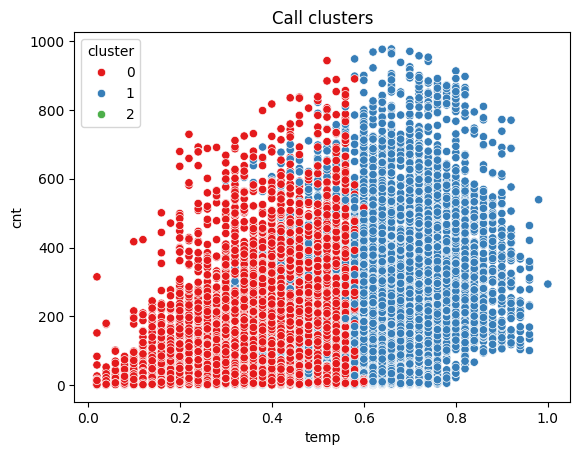

Anomalies:
            date  cnt   z_score
10383 2012-03-13  734  3.002063
10406 2012-03-14  782  3.266689
10407 2012-03-14  749  3.084758
10431 2012-03-15  746  3.068219
10527 2012-03-19  801  3.371437
...          ...  ...       ...
15828 2012-10-26  817  3.459646
15848 2012-10-27  760  3.145402
15849 2012-10-27  750  3.090271
16726 2012-12-04  743  3.051680
16741 2012-12-05  759  3.139889

[244 rows x 3 columns]


In [16]:
scaler = StandardScaler()
scaled_features = scaler.fit_transform(X)


kmeans = KMeans(n_clusters=3, random_state=42)
data['cluster'] = kmeans.fit_predict(scaled_features)


sns.scatterplot(data=data, x='temp', y='cnt', hue='cluster', palette='Set1')
plt.title("Call clusters")
plt.show()

data['z_score'] = (data['cnt'] - data['cnt'].mean()) / data['cnt'].std()
anomalies = data[data['z_score'].abs() > 3]
print("Anomalies:")
print(anomalies[['date', 'cnt', 'z_score']])

Date Conversion: The date column was converted into a proper datetime format to facilitate easier time-based analysis. <br>
Categorical Data Encoding: Categorical variables like season, holiday, weekday, workingday, and weathersit were converted into integer or categorical types. <br>
Normalization: Several features such as temp, atemp, hum, and windspeed are normalized scaled between 0 and 1, which simplifies model interpretation and enhances model performance. <br>
Feature Engineering: In addition to the existing features, I created new features like the hour of the day and season to better understand hourly and seasonal patterns.

### Distribution of Ambulance Calls <br>
4000 records show between 0-40 calls. <br>
1500 records show between 40-80 calls. <br>
A small number of records report significantly higher numbers of calls (e.g., 700-800 calls in certain cases).

### Seasonal Trends 
Autumn (season 3) has the highest average call count, around 220 calls per hour. <br>
Spring (season 1) has the lowest average call count, around 100 calls per hour. <br>
Summer (season 2) and Winter (season 4) both have similar call counts, with an average of around 200 calls per hour.

### Hourly Trends 
0 hour (midnight) has the lowest number of calls (~60 calls).<br>
7 hour (morning) sees a peak of around 350 calls.<br>
10 hour and 15 hour see moderate call counts (~200-250 calls).<br>
17 hour (evening) has the highest volume, with 450 calls.


### Model Selection

Several machine learning models were selected for regression analysis to predict the ambulance call count (cnt) based on environmental and seasonal factors. These models include: <br>

**Linear Regression**: A simple, interpretable model that can provide a baseline for comparison.<br>
**Random Forest Regressor**: An ensemble model that can capture complex relationships in the data without the need for explicit feature engineering.<br>
**Gradient Boosting Regressor**: A powerful boosting model that builds an ensemble of weak learners to improve predictive accuracy.<br>
**XGBoost**: A highly optimized and scalable gradient boosting algorithm that often performs well with structured data.<br>

### Model Evaluation
MAE (Mean Absolute Error): Measures the average magnitude of errors in predictions. <br>
RMSE (Root Mean Squared Error): Measures the square root of the average squared differences between predicted and actual values, giving more weight to larger errors.<br>
R² (Coefficient of Determination): Measures the proportion of variance in the dependent variable that is predictable from the independent variables.

### **Model Results**

| Model               | MAE   | RMSE  | R²    |
|---------------------|-------|-------|-------|
| **Linear Regression** | 105.52 | 142.54 | 0.36 |
| **Random Forest**     | 43.79  | 67.68  | 0.86 |
| **Gradient Boosting** | 57.07  | 83.46  | 0.78 |
| **XGBoost**           | 44.05  | 66.14  | 0.86 |

### **Anomalies Detected**

| Date       | Calls | Z-Score |
|------------|-------|---------|
| 2012-03-13 | 734   | 3.00    |
| 2012-03-14 | 782   | 3.27    |
| 2012-03-14 | 749   | 3.08    |
| 2012-03-15 | 746   | 3.07    |
| 2012-03-19 | 801   | 3.37    |


## Conclusion
The Random Forest and XGBoost models provided the best results for predicting the number of ambulance calls, with both achieving an R² of 0.86.<br><br>
Seasonal and hourly trends were observed, indicating that certain times of day and seasons (especially autumn) are associated with higher ambulance call volumes.<br><br>
Anomalies in the data were successfully identified using the Z-score method, and these anomalies could potentially be linked to special events, weather conditions,<br> or other external factors.